In [23]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as geopd
import numpy as np
import seaborn as sns
import os

In [3]:
data = pd.read_csv('data/Napoli.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7904 entries, 0 to 7903
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   COD_RIP                7904 non-null   int64  
 1   COD_REG                7904 non-null   int64  
 2   COD_PROV_STORICO       7904 non-null   int64  
 3   COD_UTS                7904 non-null   int64  
 4   PRO_COM_T              7904 non-null   int64  
 5   PRO_COM                7904 non-null   int64  
 6   COMUNE                 7903 non-null   object 
 7   COMUNE_IT              7903 non-null   object 
 8   COMUNE_A               124 non-null    object 
 9   DEN_RIP                7904 non-null   object 
 10  DEN_REG                7904 non-null   object 
 11  DEN_UTS                7904 non-null   object 
 12  TIPO_UTS               7904 non-null   int64  
 13  CC_REG                 7904 non-null   int64  
 14  CC_UTS                 7904 non-null   int64  
 15  SIGL

In [5]:
# Filtra provincia di Napoli
data_napoli = data[data['DEN_UTS'] == 'Napoli']

# Comuni su isole da escludere
comuni_isole = [
    "Ischia",
    "Casamicciola Terme",
    "Lacco Ameno",
    "Forio",
    "Serrara Fontana",
    "Barano d'Ischia",
    "Procida",
    "Capri",
    "Anacapri"
]

# Escludi i comuni sulle isole
Napoli = data_napoli[~data_napoli["COMUNE"].isin(comuni_isole)]

# Selezione colonne
Napoli = Napoli[[
    "COMUNE",
    "Latitudine",
    "Longitudine",
    "POP21",
    "FAM21",
    "SUPERFICIE"
]].reset_index(drop=True)



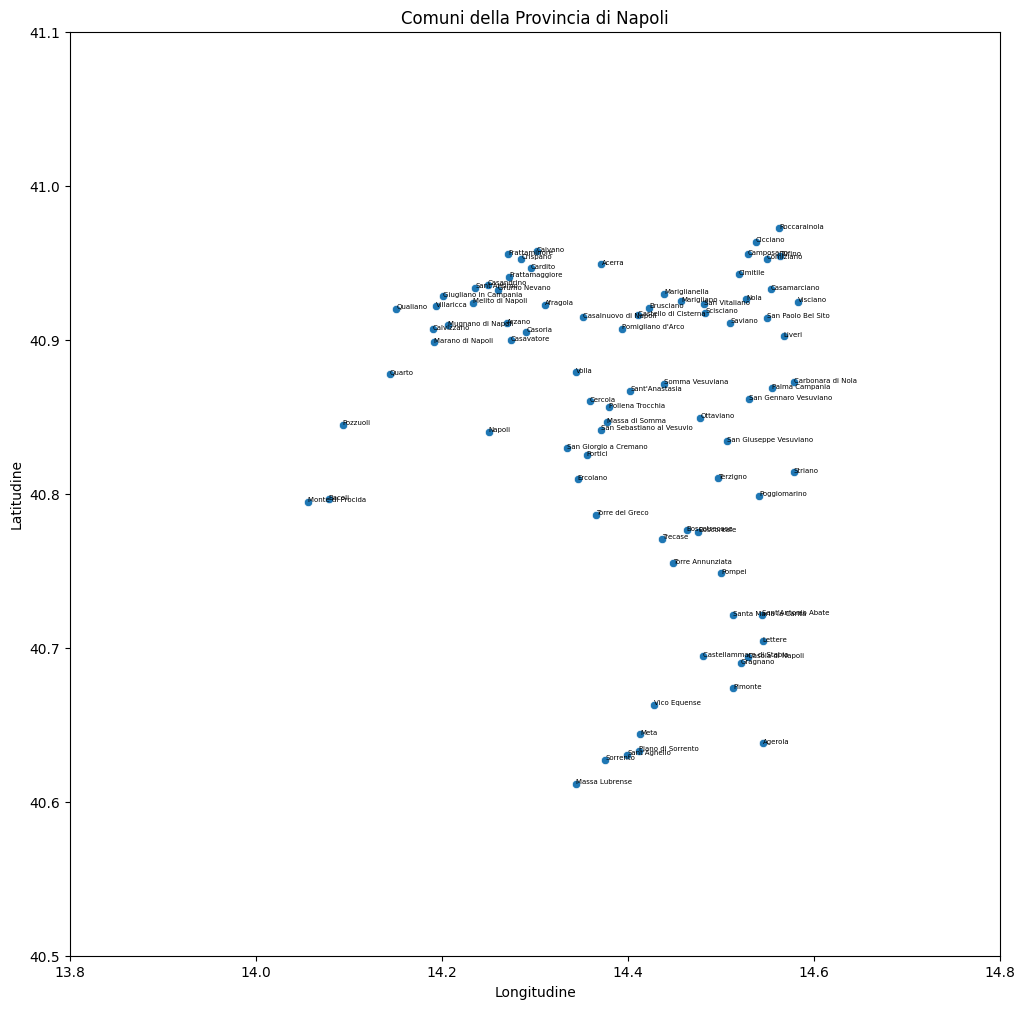

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.scatterplot(data = Napoli, y='Latitudine', x='Longitudine', ax=ax)

ax.set_xlim(13.8, 14.8) 
ax.set_ylim(40.5, 41.1)

for _, row in Napoli.iterrows():
    ax.text(row["Longitudine"], row["Latitudine"], row["COMUNE"], fontsize=5)

plt.title("Comuni della Provincia di Napoli")
plt.savefig('mappa_napoli.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # raggio terrestre in metri

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


lat = Napoli["Latitudine"].values
lon = Napoli["Longitudine"].values
n = len(lat)

dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = haversine(lat[i], lon[i], lat[j], lon[j])

distances = pd.DataFrame(dist_matrix, index=Napoli["COMUNE"], columns=Napoli["COMUNE"])


In [8]:
nomi_5 = Napoli['COMUNE'].iloc[:5].tolist()
matrice_5x5 = distances.iloc[:5, :5] / 1000 
df_estratto = pd.DataFrame(matrice_5x5.values, index=nomi_5, columns=nomi_5).round(2)

styled_table = df_estratto.style.background_gradient(cmap='Blues').format("{:.2f} km")
display(styled_table)

print("\n--- COPIA IL CODICE QUI SOTTO PER OVERLEAF ---")
print(df_estratto.to_latex())

plt.figure(figsize=(10, 8))
sns.heatmap(df_estratto, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'km'})
plt.title("Mappa di Calore delle Distanze (km)")
plt.savefig('matrice_calore.png', dpi=300, bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')

tabella_img = ax.table(cellText=df_estratto.values, 
                       colLabels=df_estratto.columns, 
                       rowLabels=df_estratto.index,
                       loc='center', 
                       cellLoc='center')

tabella_img.auto_set_font_size(False)
tabella_img.set_fontsize(12)
tabella_img.scale(1.2, 2.5)

for (row, col), cell in tabella_img.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#2c3e50')
    else:
        cell.set_facecolor('#ecf0f1')

plt.savefig('matrice_distanze.png', dpi=300, bbox_inches='tight')
plt.close()


,Acerra,Afragola,Agerola,Arzano,Bacoli
Acerra,0.00 km,5.88 km,37.53 km,9.58 km,29.93 km
Afragola,5.88 km,0.00 km,37.31 km,3.72 km,24.07 km
Agerola,37.53 km,37.31 km,0.00 km,38.18 km,43.13 km
Arzano,9.58 km,3.72 km,38.18 km,0.00 km,20.49 km
Bacoli,29.93 km,24.07 km,43.13 km,20.49 km,0.00 km



--- COPIA IL CODICE QUI SOTTO PER OVERLEAF ---
\begin{tabular}{lrrrrr}
\toprule
 & Acerra & Afragola & Agerola & Arzano & Bacoli \\
\midrule
Acerra & 0.000000 & 5.880000 & 37.530000 & 9.580000 & 29.930000 \\
Afragola & 5.880000 & 0.000000 & 37.310000 & 3.720000 & 24.070000 \\
Agerola & 37.530000 & 37.310000 & 0.000000 & 38.180000 & 43.130000 \\
Arzano & 9.580000 & 3.720000 & 38.180000 & 0.000000 & 20.490000 \\
Bacoli & 29.930000 & 24.070000 & 43.130000 & 20.490000 & 0.000000 \\
\bottomrule
\end{tabular}



In [9]:
bins = [-1, 0, 15000, 30000, 45000, 65000]
labels = ["0","1", "2", "3", "4"]

dist_levels = pd.DataFrame(
    pd.cut(distances.values.flatten(), bins=bins, labels=labels)
    .reshape(distances.shape),
    index=distances.index,
    columns=distances.columns
)


In [10]:
Napoli['Domanda'] = Napoli['FAM21'] * 2 # media ordini in Italia

In [11]:
percentuali_di_compliance = {
    "0": 1,
    "1": 0.8,
    "2": 0.6,
    "3": 0.4,
    "4": 0.2,
}

sconto da applicare sul ricavo unitario per utilizzo del servizio

In [12]:
sconto = {
    "0": 0,
    "1": 0.15,
    "2": 0.25,
    "3": 0.30,
    "4": 0.35
}

In [13]:
domanda = Napoli['Domanda'].values.reshape(-1, 1)

In [14]:
costi_fissi_e_operativi = 7500 + 0.85 * domanda

In [15]:
# Insiemi
I = range(30)          # nodi i
U = range(5)        # livelli di distanza u = 0,...,m

     # costo fisso di installazione
# costo fisso per nodo i
f = {i: float(costi_fissi_e_operativi[i]) for i in I}  # costo fisso, unico per tutti i nodi

# domanda per nodo i
Q = {i: float(domanda[i]) for i in I}

# sconti e percentuali di compliance
Cd = {int(k): float(v) for k, v in sconto.items()}
rho = {int(k): float(v) for k, v in percentuali_di_compliance.items()}

# Insiemi di copertura dei livelli
# S[i][u] = insieme dei nodi j nel livello u rispetto a i

S = {i: {u: [] for u in U} for i in I}

for i in I:
    for j in I:
        u = int(dist_levels.iloc[i, j])   # ← FIX
        S[i][u].append(j)

/var/folders/nf/0yfd5sbj61zggffg8w3y68th0000gn/T/ipykernel_82045/526434762.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f = {i: float(costi_fissi_e_operativi[i]) for i in I}  # costo fisso, unico per tutti i nodi
/var/folders/nf/0yfd5sbj61zggffg8w3y68th0000gn/T/ipykernel_82045/526434762.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q = {i: float(domanda[i]) for i in I}


In [39]:
model = gp.Model("Locker_Location_Multilevel")

In [40]:
x = model.addVars(I, vtype=GRB.BINARY, name="x")       # locker aperti
y = model.addVars(I, U, lb=0.0, name="y")             # frazione clienti assegnata
l = model.addVars(I, U, vtype=GRB.BINARY, name="l")   # indicatore livello aperto

In [41]:
model.setObjective(
    gp.quicksum(
        f[i] * x[i] 
        + Q[i]*gp.quicksum((R * Cd[u] - R)*rho[u]*y[i,u] for u in U)
        for i in I
    ),
    GRB.MINIMIZE
)

In [42]:
model.addConstrs(
    (y[i, u] <= l[i, u] for i in I for u in U),
    name="AssignmentConsistency"
)

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (3, 0): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (3, 4): <gurobi.Constr *Awaiting Model Update*>,


In [43]:
model.addConstrs(
    (gp.quicksum(y[i, u] for u in U) == 1 for i in I),
    name="DemandCoverage"
)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [44]:
model.addConstrs(
    (l[i, u] <= gp.quicksum(x[j] for j in S[i][u]) for i in I for u in U),
    name="LevelUpperBound"
)

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (3, 0): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (3, 4): <gurobi.Constr *Awaiting Model Update*>,


In [45]:
model.addConstrs(
    (l[i, u] >= x[j] for i in I for u in U for j in S[i][u]),
    name="LevelLowerBound"
)

{(0, 0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 20): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 21): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 22): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 23): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 24): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 25): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 26): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 27): <gurobi.Constr *Awai

In [46]:
model.optimize()

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1230 rows, 330 columns and 3300 nonzeros (Min)
Model fingerprint: 0x3accf0cb
Model has 180 linear objective coefficients
Variable types: 150 continuous, 180 integer (180 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+02, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -1007981.800
Presolve removed 298 rows and 120 columns
Presolve time: 0.03s
Presolved: 932 rows, 210 columns, 2582 nonzeros
Variable types: 118 continuous, 92 integer (92 binary)

Root relaxation: objective -1.656197e+06, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

* 

In [47]:
if model.status == GRB.OPTIMAL:
    open_lockers = [i for i in I if x[i].X > 0.5]
    print("Locker aperti nei nodi:", open_lockers)

    for i in I:
        for u in U:
            if y[i,u].X > 1e-6:
                print(f"Nodo {i} → livello {u}, quota clienti {y[i,u].X:.2f}")

Locker aperti nei nodi: [0, 1, 3, 4, 5, 8, 13, 18, 19, 26, 28, 29]
Nodo 0 → livello 0, quota clienti 1.00
Nodo 1 → livello 0, quota clienti 1.00
Nodo 2 → livello 1, quota clienti 1.00
Nodo 3 → livello 0, quota clienti 1.00
Nodo 4 → livello 0, quota clienti 1.00
Nodo 5 → livello 0, quota clienti 1.00
Nodo 6 → livello 1, quota clienti 1.00
Nodo 7 → livello 1, quota clienti 1.00
Nodo 8 → livello 0, quota clienti 1.00
Nodo 9 → livello 1, quota clienti 1.00
Nodo 10 → livello 1, quota clienti 1.00
Nodo 11 → livello 1, quota clienti 1.00
Nodo 12 → livello 1, quota clienti 1.00
Nodo 13 → livello 0, quota clienti 1.00
Nodo 14 → livello 2, quota clienti 1.00
Nodo 15 → livello 1, quota clienti 1.00
Nodo 16 → livello 1, quota clienti 1.00
Nodo 17 → livello 1, quota clienti 1.00
Nodo 18 → livello 0, quota clienti 1.00
Nodo 19 → livello 0, quota clienti 1.00
Nodo 20 → livello 1, quota clienti 1.00
Nodo 21 → livello 1, quota clienti 1.00
Nodo 22 → livello 1, quota clienti 1.00
Nodo 23 → livello 1, qu

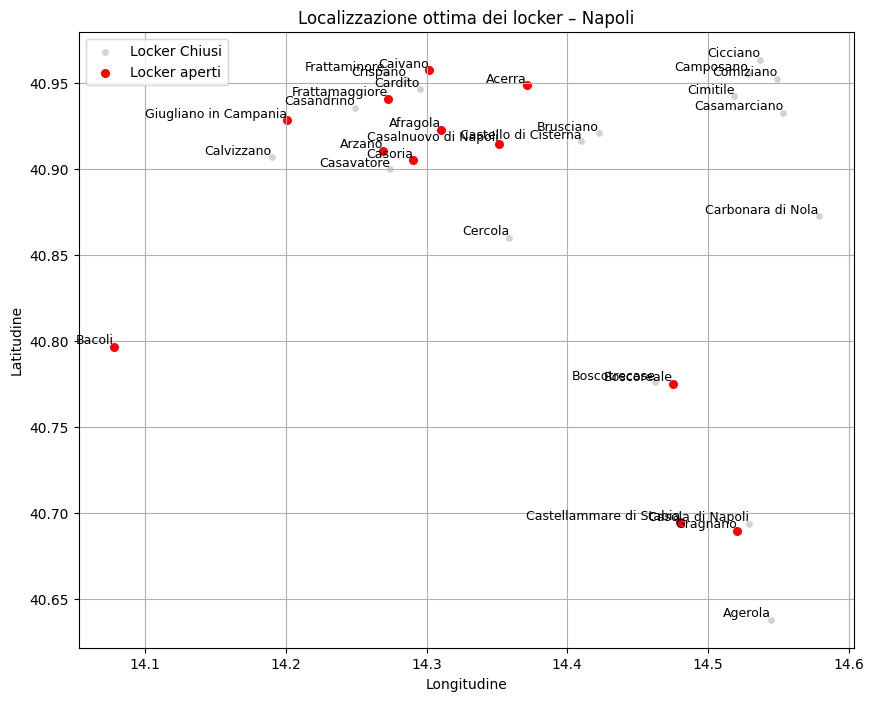

In [48]:
Napoli_subset = Napoli.iloc[0:30, :].reset_index(drop=True)

# Locker aperti dalla soluzione ottima
open_lockers = [i for i in I if x[i].X > 0.5]
locked_lockers = [i for i in I if x[i].X < 0.5]

plt.figure(figsize=(10,8))

# Tutti i nodi
plt.scatter(
    Napoli_subset["Longitudine"],
    Napoli_subset["Latitudine"],
    c='lightgray',
    s=15,
    label='Locker Chiusi'
)

# Locker aperti
plt.scatter(
    Napoli_subset.loc[open_lockers, "Longitudine"],
    Napoli_subset.loc[open_lockers, "Latitudine"],
    c='red',
    s=30,
    label='Locker aperti'
)

# 🔹 Etichette COMUNE (solo per i locker aperti, consigliato)
for i in open_lockers:
    plt.text(
        Napoli_subset.loc[i, "Longitudine"],
        Napoli_subset.loc[i, "Latitudine"],
        Napoli_subset.loc[i, "COMUNE"],
        fontsize=9,
        ha='right',
        va='bottom'
    )

for i in locked_lockers:
    plt.text(
        Napoli_subset.loc[i, "Longitudine"],
        Napoli_subset.loc[i, "Latitudine"],
        Napoli_subset.loc[i, "COMUNE"],
        fontsize=9,
        ha='right',
        va='bottom'
    )


plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
plt.title("Localizzazione ottima dei locker – Napoli")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ricavi = np.array([3, 3.25, 3.5, 3.75, 4])

results_model = []
results_assignment = []

Napoli_subset = Napoli.iloc[0:30, :].reset_index(drop=True) ## CON LA NUOVA LICENZA QUESTA PARTE DA ELIMINARE, SOSTITUIRE NELLE PARTI SUCCESSIVE Napoli_subset con Napoli

# Cartella output grafici
output_dir = "plots_locker_location"
os.makedirs(output_dir, exist_ok=True)

for R in ricavi:

    model = gp.Model(f"Locker_Location_R_{R}")
    model.Params.OutputFlag = 0

    # =====================
    # Variabili
    # =====================
    x = model.addVars(I, vtype=GRB.BINARY, name="x")
    y = model.addVars(I, U, lb=0.0, name="y")
    l = model.addVars(I, U, vtype=GRB.BINARY, name="l")

    # =====================
    # Obiettivo
    # =====================
    model.setObjective(
        gp.quicksum(
            f[i] * x[i]
            + Q[i] * gp.quicksum((R * Cd[u] - R) * rho[u] * y[i, u] for u in U)
            for i in I
        ),
        GRB.MINIMIZE
    )

    # =====================
    # Vincoli
    # =====================
    model.addConstrs(
        (y[i, u] <= l[i, u] for i in I for u in U),
        name="AssignmentConsistency"
    )

    model.addConstrs(
        (gp.quicksum(y[i, u] for u in U) == 1 for i in I),
        name="DemandCoverage"
    )

    model.addConstrs(
        (l[i, u] <= gp.quicksum(x[j] for j in S[i][u]) for i in I for u in U),
        name="LevelUpperBound"
    )

    model.addConstrs(
        (l[i, u] >= x[j] for i in I for u in U for j in S[i][u]),
        name="LevelLowerBound"
    )

    # =====================
    # Ottimizzazione
    # =====================
    model.optimize()

    if model.status != GRB.OPTIMAL:
        continue

    open_lockers = [i for i in I if x[i].X > 0.5]
    locked_lockers = [i for i in I if x[i].X < 0.5]

    # =====================
    # Salvataggio risultati
    # =====================
    results_model.append({
        "Ricavo": R,
        "ObjValue": model.ObjVal,
        "NumLockerAperti": len(open_lockers)
    })

    for i in I:
        for u in U:
            if y[i, u].X > 1e-6:
                results_assignment.append({
                    "Ricavo": R,
                    "Nodo": i,
                    "Livello": u,
                    "y": y[i, u].X,
                    "x": int(x[i].X > 0.5),
                    "l": int(l[i, u].X > 0.5)
                })

    # =====================
    # SCATTERPLOT SALVATO
    # =====================
    plt.figure(figsize=(10, 8))

    # Tutti i nodi
    plt.scatter(
        Napoli_subset["Longitudine"],
        Napoli_subset["Latitudine"],
        c='lightgray',
        s=15,
        label='Locker chiusi'
    )

    # Locker aperti
    plt.scatter(
        Napoli_subset.loc[open_lockers, "Longitudine"],
        Napoli_subset.loc[open_lockers, "Latitudine"],
        c='red',
        s=35,
        label='Locker aperti'
    )

    # Centroidi di domanda
    plt.scatter(
        Napoli_subset["Longitudine"],
        Napoli_subset["Latitudine"],
        c='blue',
        s=50,
        marker='x',
        label='Centroidi domanda'
    )

    # Etichette COMUNE (solo locker aperti)
    for i in open_lockers:
        plt.text(
            Napoli_subset.loc[i, "Longitudine"],
            Napoli_subset.loc[i, "Latitudine"],
            Napoli_subset.loc[i, "COMUNE"],
            fontsize=8,
            ha='right',
            va='bottom'
        )

    plt.xlabel("Longitudine")
    plt.ylabel("Latitudine")
    plt.title(f"Localizzazione ottima locker – Napoli (Ricavo = {R})")
    plt.legend()
    plt.grid(True)

    filename = f"locker_location_R_{R}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches="tight")
    plt.close()

# =====================
# DataFrame finali
# =====================
df_model = pd.DataFrame(results_model)
df_assignment = pd.DataFrame(results_assignment)
